In [1]:
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from torchvision.models import detection
import torchvision
import torch.nn as nn
from tqdm import tqdm, tqdm_notebook
from PIL import Image
import pandas as pd

In [3]:
!pip install colormath

  Created wheel for colormath: filename=colormath-3.0.0-py3-none-any.whl size=39408 sha256=7472f05c717f8aea3acbea6e802313220d8828b41c2541c9090bda5fbd136aa6
  Stored in directory: /root/.cache/pip/wheels/1a/d7/a7/458a4632ccc8bfe436f5e9db9fef1aa84e5d243a1b4b4c7b59
Successfully built colormath


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
!pip install opencv-contrib-python --upgrade

     |████████████████████████████████| 66.5 MB 7.2 kB/s 
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


In [6]:
import cv2
print(cv2.__version__)

4.5.4-dev


In [7]:
class Mock():
    def __init__(self, out_size):
        self.out_size = out_size

    def eval(self):
        pass
    
    def __call__(self, x):
        return torch.ones((x.size()[0], self.out_size))

In [8]:
!unzip -q drive/MyDrive/'Colab Notebooks'/name.zip

In [9]:
def get_cropped_image(picture, coordinates, expand_coeff=2.0):
        '''
            picture: torch.Tensor
            coordinates: "indexed set" of 4 coordinates: [x1, y1, x2, y2]
        '''
        x = coordinates[0]
        y = coordinates[1]
        w = coordinates[2] - coordinates[0]
        h = coordinates[3] - coordinates[1]
        w_expanded = int(w * expand_coeff)
        h_expanded = int(h * expand_coeff)
        x_expanded = int(x - (w_expanded - w) / 2.0)
        y_expanded = int(y - (h_expanded - h) / 2.0)

        return torchvision.transforms.functional.crop(
            picture, 
            int(y_expanded), 
            int(x_expanded), 
            int(h_expanded), 
            int(w_expanded),
        )

In [10]:
class ColorDetector():
    def __init__(self, colors, THRESHOLD=1./8):
        self.THRESHOLD = THRESHOLD
        self.colors = np.array(colors)
    
    def __call__(self, image):
        image = image[0]
        h = int(self.THRESHOLD * image.shape[1])
        w = int(self.THRESHOLD * image.shape[2])
        x1 = image.shape[2] // 2 - w // 2
        y1 = image.shape[1] // 2 - h // 2
        x2 = image.shape[2] // 2 + w // 2
        y2 = image.shape[1] // 2 + h // 2
        cropped_image = get_cropped_image(image, [x1, y1, x2, y2], expand_coeff=1.0)
        plt.imshow(cropped_image.permute(1, 2, 0).detach().numpy())
        plt.show()
        color = [0] * cropped_image.shape[0]
        for channel in range(cropped_image.shape[0]):
            color[channel] = cropped_image[channel].mean().item() * 256
        color = np.array(color)
        return np.argmin(np.sum((self.colors - color) ** 2.0, axis=1))

In [11]:
tails_converter = {
    "Japanese_spaniel": "short",
    "Pekinese": "short",
    "Blenheim_spaniel": "short",
    "toy_terrier": "short",
    "Rhodesian_ridgeback": "long",
    "basset": "long",
    "beagle": "long",
    "bluetick": "long",
    "black-and-tan_coonhound": "long",
    "Walker_hound": "long",
    "English_foxhound": "long",
    "redbone": "long",
    "borzoi": "long",
    "Norwegian_elkhound": "short",
    "Scottish_deerhound": "long",
    "Weimaraner": "short",
    "Staffordshire_bullterrier": "short",
    "American_Staffordshire_terrier": "short",
    "Border_terrier": "short",
    "Irish_terrier": "long",
    "Norfolk_terrier": "short",
    "Norwich_terrier": "short",
    "Yorkshire_terrier": "short",
    "wire-haired_fox_terrier": "short",
    "Lakeland_terrier": "short",
    "Airedale": "short",
    "cairn": "short",
    "giant_schnauzer": "short",
    "standard_schnauzer": "short",
    "soft-coated_wheaten_terrier": "short",
    "soft-coated_wheaten_terrier": "short",
    "West_Highland_white_terrier": "short",
    "flat-coated_retriever": "long",
    "golden_retriever": "long",
    "Labrador_retriever": "long",
    "Chesapeake_Bay_retriever": "long",
    "Irish_setter": "long",
    "Gordon_setter": "long",
    "Brittany_spaniel": "short",
    "Welsh_springer_spaniel": "short",
    "cocker_spaniel": "short",
    "Sussex_spaniel": "long",
    "Irish_water_spaniel": "short",
    "briard": "long",
    "kelpie": "long",
    "Shetland_sheepdog": "short",
    "collie": "short",
    "Rottweiler": "short",
    "Doberman": "short",
    "boxer": "short",
    "Tibetan_mastiff": "long",
    "malamute": "long",
    "Siberian_husky": "long",
    "pug": "short",
    "Leonberg": "long",
    "Newfoundland": "long",
    "Great_Pyrenees": "long",
    "Samoyed": "short",
    "Pomeranian": "short",
    "chow": "short",
    "standard_poodle": "short",
    "dingo": "long",
}

In [ ]:
inst_classes = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

In [ ]:
colors = {"orange": (255,165,0),"gold": (255,215,0),"dark golden rod": (184,134,11),"golden rod": (218,165,32),"pale golden rod": (238,232,170),"dark khaki": (189,183,107),"khaki": (240,230,140),"olive": (128,128,0),"yellow": (255,255,0),"yellow green": (154,205,50),"dark olive green": (85,107,47),"olive drab": (107,142,35),"lawn green": (124,252,0),"chart reuse": (127,255,0),"green yellow": (173,255,47),"dark green": (0,100,0),"green": (0,128,0),"forest green": (34,139,34),"lime": (0,255,0),"lime green": (50,205,50),"light green": (144,238,144),"pale green": (152,251,152),"dark sea green": (143,188,143),"medium spring green": (0,250,154),"spring green": (0,255,127),"sea green": (46,139,87),"medium aqua marine": (102,205,170),"medium sea green": (60,179,113),"light sea green": (32,178,170),"dark slate gray": (47,79,79),"teal": (0,128,128),"dark cyan": (0,139,139),"aqua": (0,255,255),"cyan": (0,255,255),"light cyan": (224,255,255),"dark turquoise": (0,206,209),"turquoise": (64,224,208),"medium turquoise": (72,209,204),"pale turquoise": (175,238,238),"aqua marine": (127,255,212),"powder blue": (176,224,230),"cadet blue": (95,158,160),"steel blue": (70,130,180),"corn flower blue": (100,149,237),"deep sky blue": (0,191,255),"dodger blue": (30,144,255),"light blue": (173,216,230),"sky blue": (135,206,235),"light sky blue": (135,206,250),"midnight blue": (25,25,112),"navy": (0,0,128),"dark blue": (0,0,139),"medium blue": (0,0,205),"blue": (0,0,255),"royal blue": (65,105,225),"blue violet": (138,43,226),"indigo": (75,0,130),"dark slate blue": (72,61,139),"slate blue": (106,90,205),"medium slate blue": (123,104,238),"medium purple": (147,112,219),"dark magenta": (139,0,139),"dark violet": (148,0,211),"dark orchid": (153,50,204),"medium orchid": (186,85,211),"purple": (128,0,128),"thistle": (216,191,216),"plum": (221,160,221),"violet": (238,130,238),"magenta / fuchsia": (255,0,255),"orchid": (218,112,214),"medium violet red": (199,21,133),"pale violet red": (219,112,147),"deep pink": (255,20,147),"hot pink": (255,105,180),"light pink": (255,182,193),"pink": (255,192,203),"antique white": (250,235,215),"beige": (245,245,220),"bisque": (255,228,196),"blanched almond": (255,235,205),"wheat": (245,222,179),"corn silk": (255,248,220),"lemon chiffon": (255,250,205),"light golden rod yellow": (250,250,210),"light yellow": (255,255,224),"saddle brown": (139,69,19),"sienna": (160,82,45),"chocolate": (210,105,30),"peru": (205,133,63),"sandy brown": (244,164,96),"burly wood": (222,184,135),"tan": (210,180,140),"rosy brown": (188,143,143),"moccasin": (255,228,181),"navajo white": (255,222,173),"peach puff": (255,218,185),"misty rose": (255,228,225),"lavender blush": (255,240,245),"linen": (250,240,230),"old lace": (253,245,230),"papaya whip": (255,239,213),"sea shell": (255,245,238),"mint cream": (245,255,250),"slate gray": (112,128,144),"light slate gray": (119,136,153),"light steel blue": (176,196,222),"lavender": (230,230,250),"floral white": (255,250,240),"alice blue": (240,248,255),"ghost white": (248,248,255),"honeydew": (240,255,240),"ivory": (255,255,240),"azure": (240,255,255),"snow": (255,250,250),"black": (0,0,0),"dim gray / dim grey": (105,105,105),"gray / grey": (128,128,128),"dark gray / dark grey": (169,169,169),"silver": (192,192,192),"light gray / light grey": (211,211,211),"gainsboro": (220,220,220),"white smoke": (245,245,245),"white": (255,255,255),}

In [ ]:
colors_vec = list(colors.values())
colors_names = list(colors.keys())
colors_index = {i: colors_names[i] for i in range(len(colors))}
print(colors_vec)
print(colors_names)
# colors_rev =  {value : key for (key, value) in a_dictionary.items()}

[(255, 165, 0), (255, 215, 0), (184, 134, 11), (218, 165, 32), (238, 232, 170), (189, 183, 107), (240, 230, 140), (128, 128, 0), (255, 255, 0), (154, 205, 50), (85, 107, 47), (107, 142, 35), (124, 252, 0), (127, 255, 0), (173, 255, 47), (0, 100, 0), (0, 128, 0), (34, 139, 34), (0, 255, 0), (50, 205, 50), (144, 238, 144), (152, 251, 152), (143, 188, 143), (0, 250, 154), (0, 255, 127), (46, 139, 87), (102, 205, 170), (60, 179, 113), (32, 178, 170), (47, 79, 79), (0, 128, 128), (0, 139, 139), (0, 255, 255), (0, 255, 255), (224, 255, 255), (0, 206, 209), (64, 224, 208), (72, 209, 204), (175, 238, 238), (127, 255, 212), (176, 224, 230), (95, 158, 160), (70, 130, 180), (100, 149, 237), (0, 191, 255), (30, 144, 255), (173, 216, 230), (135, 206, 235), (135, 206, 250), (25, 25, 112), (0, 0, 128), (0, 0, 139), (0, 0, 205), (0, 0, 255), (65, 105, 225), (138, 43, 226), (75, 0, 130), (72, 61, 139), (106, 90, 205), (123, 104, 238), (147, 112, 219), (139, 0, 139), (148, 0, 211), (153, 50, 204), (186,

In [ ]:
# picture: torch.Tensor or np.array
# boxes: indexed object
# labels: indexed object
def draw_pic_with_rect(picture, boxes, labels, n=5):
    boxes = boxes[:n]
    labels = labels[:n]
    if isinstance(picture, torch.Tensor):
        picture = (picture.detach().squeeze(0) * 256).permute(1, 2, 0).numpy()
    picture = picture.astype(dtype=np.int)

    fig, ax = plt.subplots(figsize = (15, 15))
    ax.imshow(picture)

    for box, lab in zip(boxes, labels):
        rect = matplotlib.patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1],
                                       linewidth=1, edgecolor='r', facecolor='none')
        ax.text(box[0], box[1], inst_classes[lab], fontsize = 12)
        ax.add_patch(rect)

    fig.show()

In [ ]:
indices_animal_detection = [
    inst_classes.index("bird"),
    inst_classes.index("cat"),
    inst_classes.index("dog"),
    inst_classes.index("horse"),
    inst_classes.index("sheep"),
    inst_classes.index("cow"),
    inst_classes.index("elephant"),
    inst_classes.index("bear"),
    inst_classes.index("zebra"),
    inst_classes.index("giraffe"),
    inst_classes.index("bench"), # TODO
]

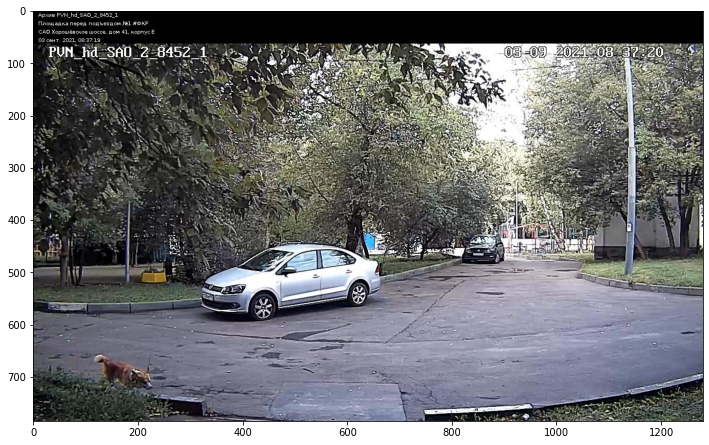

In [ ]:
image = Image.open("/content/Датасет/Только собака/ТОЛЬКО СОБАКА ТЕМНЫЙ ДЛИННЫЙ/326.jpg")
image_numpy = np.asarray(image)
plt.figure(figsize=(12, 10))
plt.imshow(image_numpy);
# find_lost_animal.get_features(image_numpy)

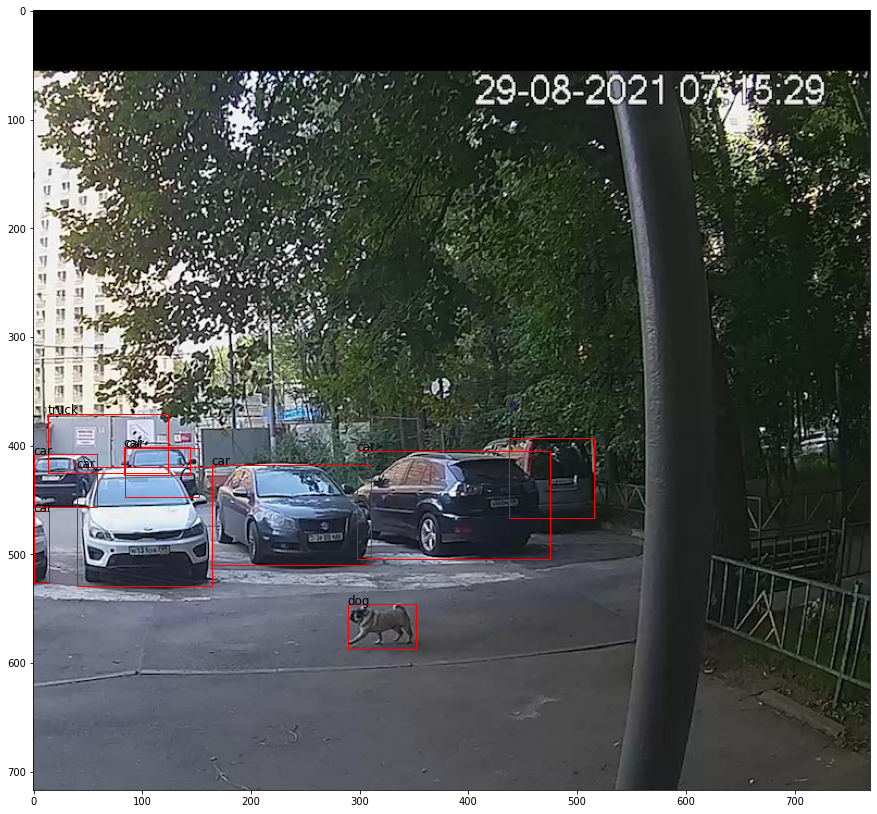

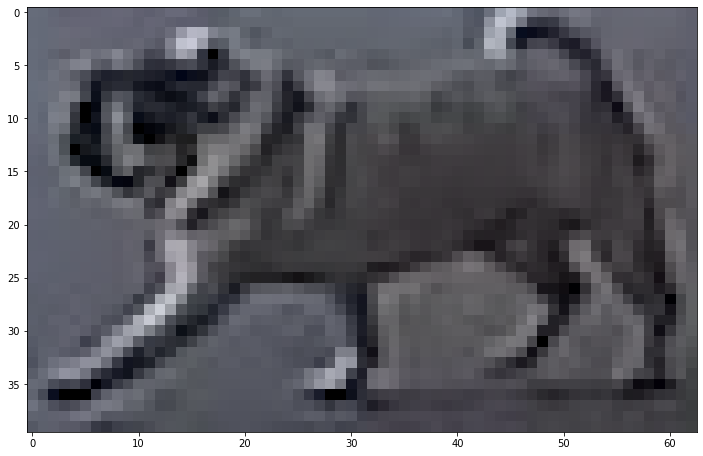

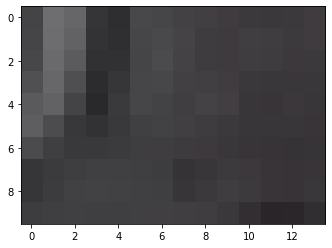

[[['American_Staffordshire_terrier', 'boxer', 'Staffordshire_bullterrier'], 'dark slate gray', 'enormous']]


In [ ]:
class FindLostAnimal():
    def __init__(self, 
                 model_detection,
                 model_classification_animal,
                 model_classification_dog_breed,
                 model_classification_dog_color,
                 model_classification_dog_tail,
                 indices_animal_detection,
                 indices_cat_dog_classification,
                 converter_dog_breed,
                 converter_dog_color,
                 converter_dog_tail,
                 converter_dog_tail_via_breed,
                 model_superresolution,
        ):

        self.model_detection = model_detection
        self.model_classification_animal = model_classification_animal
        self.model_classification_dog_breed = model_classification_dog_breed
        self.model_classification_dog_color = model_classification_dog_color
        self.model_classification_dog_tail = model_classification_dog_tail
        self.indices_cat_dog_classification = indices_cat_dog_classification
        self.indices_animal_detection  = indices_animal_detection
        self.converter_dog_breed = converter_dog_breed
        self.converter_dog_color = converter_dog_color
        self.converter_dog_tail = converter_dog_tail
        self.converter_dog_tail_via_breed = converter_dog_tail_via_breed
        self.model_superresolution = model_superresolution

        self.transforms = torchvision.transforms.Compose([
            torchvision.transforms.Normalize(
                [0.485, 0.456, 0.406],
                [0.229, 0.224, 0.225],
            ),
            # torchvision.transforms.Resize((80, 80)),
        ])

        self.model_detection.eval()
        self.model_classification_animal.eval()
        self.model_classification_dog_breed.eval()
        # self.model_classification_dog_color.eval()
        self.model_classification_dog_tail.eval()


    def __get_cropped_image(self, picture, coordinates, expand_coeff=2.0):
        '''
            picture: torch.Tensor
            coordinates: "indexed set" of 4 coordinates: [x1, y1, x2, y2]
        '''
        x = coordinates[0]
        y = coordinates[1]
        w = coordinates[2] - coordinates[0]
        h = coordinates[3] - coordinates[1]
        w_expanded = int(w * expand_coeff)
        h_expanded = int(h * expand_coeff)
        x_expanded = int(x - (w_expanded - w) / 2.0)
        y_expanded = int(y - (h_expanded - h) / 2.0)

        return torchvision.transforms.functional.crop(
            picture, 
            int(y_expanded), 
            int(x_expanded), 
            int(h_expanded), 
            int(w_expanded),
        )        


    def __get_detection_predictions(self, picture):
        '''
            returns boxes and labels
        '''
        pred = self.model_detection(picture)
        return pred[0]["boxes"], pred[0]["labels"]
    
    def __get_classification_animal_predictions(self, cropped_picture):
        '''
            determines class of an animal
            returns index of the most probable class
        '''
        pred = self.model_classification_animal(cropped_picture)
        label = pred.argmax(axis=1)[0].item()
        return label


    def __convert_features(self, features):
        '''
            convert features to readable format
            return list of features
        '''
        result = []
        for data in features:
            result.append(
                [
                 [self.converter_dog_breed[str(breed)] for breed in data[0]],
                 self.converter_dog_color[data[1]], 
                 self.converter_dog_tail[data[2]], 
                ]
            )
        return result

    def __get_dog_features(self, dog_image, k=3):
        '''
            expect real image! not normalized
            return dog of features in list:
            list[0]: top 3 breeds
            list[1]: dog color
            list[2]: dog tail
        '''
        normalized_picture = self.transforms(dog_image)

        arr = self.model_classification_dog_breed(normalized_picture)[0].detach().numpy()
        ind = arr.argsort()[-k:][::-1]

        return [
                ind,
                self.model_classification_dog_color(dog_image), 
                self.model_classification_dog_tail(normalized_picture).argmax(axis=1)[0].item(), 
        ]

    def __get_tail(self, breeds):
        '''
            get tail length via breed
        '''
        res = {"short": 0, "long": 0}
        for breed in breeds:
            res[self.converter_dog_tail_via_breed[breed]] += 1
        return "short" if res["short"] > res["long"] else "long"

    
    def __save_features(self, features, saved_files, filename):
        '''
            strange funtion for saving features in csv file named "table.csv"
            returns: None
        '''
        n = len(saved_files)
        keys = [
            "src_file",              
            "croppedFileName", 
            "isSomeoneHere", 
            "color", 
            "tail", 
            "top3Breed", 
            "cam_adress", 
            "time_photographed",
        ]
        
        dictionary = {}
        
        for key in keys:
            dictionary[key] = [None] * (n + 1)

        dictionary["isSomeoneHere"][n] = 0

        dictionary["src_file"] = [filename] * (n + 1)

        for i in range(n):
            dictionary["croppedFileName"][i] = saved_files[i]
            dictionary["isSomeoneHere"][i] = 1
            dictionary["color"][i] = features[i][1]
            dictionary["tail"][i] = self.__get_tail(features[i][0]) # TODO
            dictionary["top3Breed"][i] = features[i][0]
            dictionary["cam_adress"][i] = "улица Пушкина, д. Колотушкина" # TODO
            dictionary["time_photographed"][i] = "23:59" # TODO
        table = pd.DataFrame(dictionary)
        table.to_csv("table.csv")
        
    def get_features(self, filename):

        # read the image
        image = Image.open(filename)

        # if it's a png file
        if filename[-3:] == "png":
            picture_numpy = np.asarray(image)[:, :, :3]
        else:
            picture_numpy = np.asarray(image)
            
        # array of features for dog
        features = []

        # array of names of saved cropped pictured
        saved_files = []

        # convert picture in tensor
        picture = torch.from_numpy(picture_numpy).\
        to(dtype=torch.float32).permute(2, 0, 1) / 256
        picture.unsqueeze_(0)

        # get predictions of detector
        boxes, labels = self.__get_detection_predictions(picture)

        # variable cnt shows number of cropped dog
        cnt = 0

        for box, label in zip(boxes, labels):

            # if it is an animal than we should check it
            if label in self.indices_animal_detection:
                cropped_image = self.__get_cropped_image(picture, box, 2.0)

                # don't forget to transform cropped_image due to 
                # classificators expect othed std and mean
                pred = self.__get_classification_animal_predictions(
                    self.transforms(cropped_image)
                )

                # if it is a dog
                if pred in self.indices_cat_dog_classification:
                    # self.show_picture(self.__get_cropped_image(picture, box, 1.0))

                    features.append(self.__get_dog_features(cropped_image))
                    cropped_image_numpy = (
                        self.__get_cropped_image(picture, box, 1.0)[0].\
                        permute(1, 2, 0).\
                        detach().\
                        numpy() * 256
                    ).astype(dtype=np.uint8)

                    # add better quality for picture
                    result_image = self.model_superresolution.upsample(cropped_image_numpy)
                    image = Image.fromarray(result_image)

                    # and save cropped image
                    name_of_saved_picture = "test" + str(cnt) + ".jpg"
                    saved_files.append(name_of_saved_picture)
                    image.save(name_of_saved_picture)
                    cnt += 1

        # after all iterations we have to convert features to readable format
        result_features = self.__convert_features(features)

        # save features as csv file
        self.__save_features(result_features, saved_files, filename)
        return result_features

find_lost_animal = FindLostAnimal(
    model_detection,
    model_classification_cat_dog, 
    model_classification_dog_breed,
    ColorDetector(colors_vec),
    Mock(2),
    indices_animal_detection,
    [1],
    breeds_converter,
    colors_names,
    {0: "enormous"},
    tails_converter,
    superresolution,
)


print(
    find_lost_animal.get_features("/content/Датасет/Только собака/ТОЛЬКО СОБАКА СВЕТЛЫЙ ДЛИННЫЙ/126.png")
)

# model_detection,
# model_classification_animal,
# model_classification_dog_breed,
# model_classification_dog_color,
# model_classification_dog_tail,
# indices_animal_detection,
# indices_cat_dog_classification,
# converter_dog_breed,
# converter_dog_color,
# converter_dog_tail,

In [ ]:
superresolution = cv2.dnn_superres.DnnSuperResImpl_create()
path = "FSRCNN_x4.pb"
superresolution.readModel(path)
superresolution.setModel("fsrcnn",4)

In [ ]:
breeds_converter = {"0": "Japanese_spaniel", "1": "Pekinese", "2": "Blenheim_spaniel", "3": "toy_terrier", "4": "Rhodesian_ridgeback", "5": "basset", "6": "beagle", "7": "bluetick", "8": "black-and-tan_coonhound", "9": "Walker_hound", "10": "English_foxhound", "11": "redbone", "12": "borzoi", "13": "Norwegian_elkhound", "14": "Scottish_deerhound", "15": "Weimaraner", "16": "Staffordshire_bullterrier", "17": "American_Staffordshire_terrier", "18": "Border_terrier", "19": "Irish_terrier", "20": "Norfolk_terrier", "21": "Norwich_terrier", "22": "Yorkshire_terrier", "23": "wire-haired_fox_terrier", "24": "Lakeland_terrier", "25": "Airedale", "26": "cairn", "27": "giant_schnauzer", "28": "standard_schnauzer", "29": "soft-coated_wheaten_terrier", "30": "West_Highland_white_terrier", "31": "flat-coated_retriever", "32": "golden_retriever", "33": "Labrador_retriever", "34": "Chesapeake_Bay_retriever", "35": "Irish_setter", "36": "Gordon_setter", "37": "Brittany_spaniel", "38": "Welsh_springer_spaniel", "39": "cocker_spaniel", "40": "Sussex_spaniel", "41": "Irish_water_spaniel", "42": "briard", "43": "kelpie", "44": "Shetland_sheepdog", "45": "collie", "46": "Rottweiler", "47": "Doberman", "48": "boxer", "49": "Tibetan_mastiff", "50": "malamute", "51": "Siberian_husky", "52": "pug", "53": "Leonberg", "54": "Newfoundland", "55": "Great_Pyrenees", "56": "Samoyed", "57": "Pomeranian", "58": "chow", "59": "standard_poodle", "60": "dingo"}

In [ ]:
model_classification_cat_dog(torchvision.transforms.Compose([
            torchvision.transforms.Normalize(
                [0.485, 0.456, 0.406],
                [0.229, 0.224, 0.225],
            ),
            torchvision.transforms.Resize((80, 80)),
        ])(torch.from_numpy(image_numpy).to(dtype=torch.float32).permute(2, 0, 1).unsqueeze(0)))

NameError: ignored

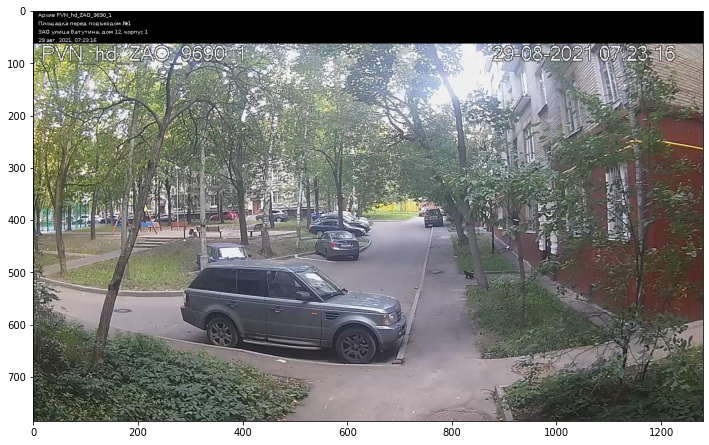

In [ ]:
# image = Image.open("/content/Датасет/Только собака/ТОЛЬКО СОБАКА ТЕМНЫЙ ДЛИННЫЙ/326.jpg")
image = Image.open("/content/Датасет/Другие животные/148.jpg")
image_numpy = np.asarray(image)
plt.figure(figsize=(12, 10))
plt.imshow(image_numpy);

image_torch = (torch.from_numpy(image_numpy).\
        to(dtype=torch.float32).permute(2, 0, 1) / 256).unsqueeze_(0)
model_detection.eval()
prediction = model_detection(image_torch)
boxes, labels = prediction[0]['boxes'], prediction[0]['labels']

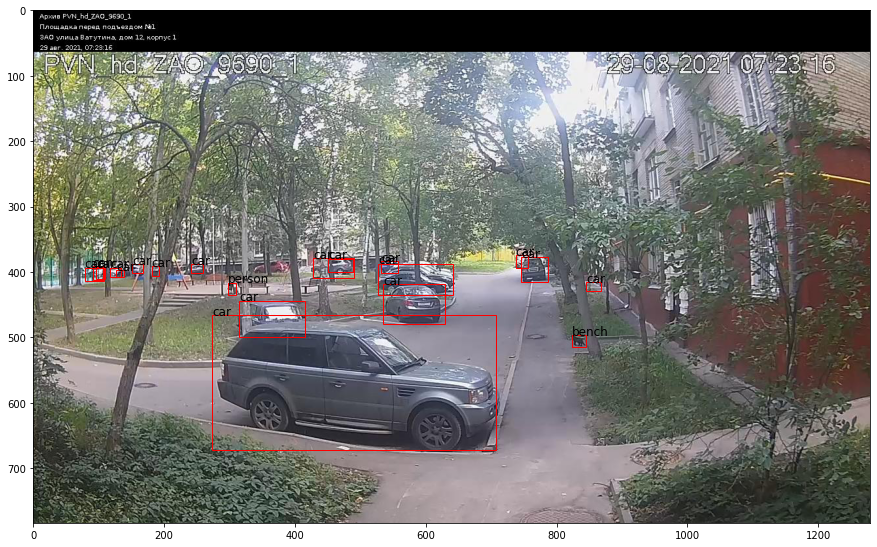

In [ ]:
draw_pic_with_rect(image_torch, boxes, labels, 20)

In [ ]:
print(labels.tolist().index(18))

2


In [ ]:
cropped_image = get_cropped_image(image_torch, boxes[2], 1.2)

In [ ]:
cropped_image_numpy = (cropped_image[0].detach().permute(1, 2, 0).numpy() * 256).astype(np.uint8)

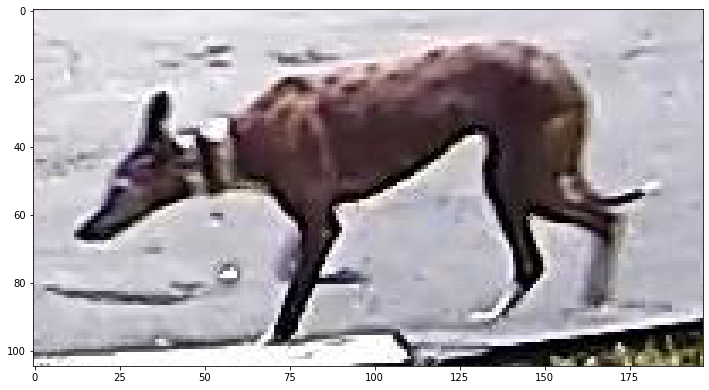

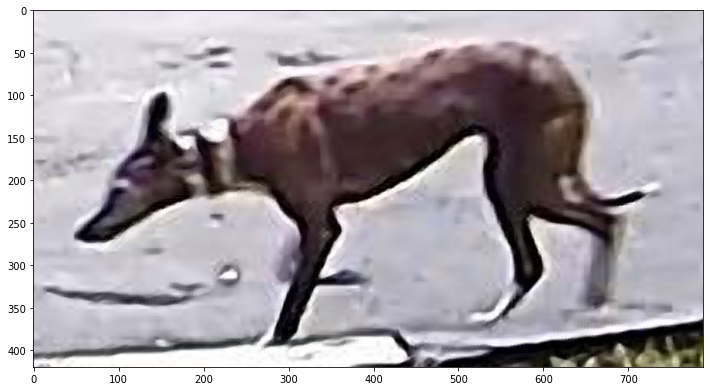

In [ ]:
sr = cv2.dnn_superres.DnnSuperResImpl_create()

path = "FSRCNN_x4.pb"
sr.readModel(path)
sr.setModel("fsrcnn",4)
result = sr.upsample(cropped_image_numpy)
plt.figure(figsize=(12,8))
plt.imshow(cropped_image_numpy)
plt.show()
plt.figure(figsize=(12,8))
plt.imshow(result)
plt.show()

In [ ]:
model_classification_cat_dog(
    torchvision.transforms.Normalize(
                [0.485, 0.456, 0.406],
                [0.229, 0.224, 0.225],
    )((torch.from_numpy(cropped_image_numpy).to(dtype=torch.float32).permute(2, 0, 1) / 256).unsqueeze_(0))
)

tensor([[-0.6505, -0.3461]], grad_fn=<AddmmBackward>)

In [ ]:
model_classification_dog_breed_fp = torchvision.\
models.resnet50(pretrained = True)

n_inputs = 1000
n_classes = 61
model_classification_dog_breed_sp = nn.Sequential(
                      nn.Linear(n_inputs, 512),
                      nn.Tanh(),
                      nn.Dropout(0.3),
                      nn.Linear(512, 256),
                      nn.ReLU(),
                      nn.Linear(256, n_classes)
                      )
model_classification_dog_breed_sp.load_state_dict(
    torch.load('/content/model_classification_dog_breeds.pt', map_location=torch.device('cpu'))
    )

model_classification_dog_breed = nn.Sequential(model_classification_dog_breed_fp, 
                                               model_classification_dog_breed_sp)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
model_classification_cat_dog_fp = torchvision.\
models.resnet101(pretrained = True)

n_inputs = 1000
n_classes = 2
torch.manual_seed(42)
model_classification_cat_dog_sp = nn.Sequential(
    nn.Linear(n_inputs, 256),
    nn.Dropout(0.4),
    nn.ReLU(),
    nn.Linear(256, 64),
    nn.Sigmoid(),
    nn.Linear(64, n_classes)
)


model_classification_cat_dog_sp.load_state_dict(
    torch.load('/content/new_model_cat_dogs_bq.pt', map_location=torch.device('cpu'))
    )

model_classification_cat_dog = nn.Sequential(model_classification_cat_dog_fp, 
                                             model_classification_cat_dog_sp)


In [ ]:
model_detection = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained = True)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]